<h1> Exploracion de los Datos (EDA) </h1>

In [2]:
import pandas as pd

df = pd.read_parquet('../data/processed/online_retail_II_cleaned.parquet')

In [ ]:
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  string        
 1   StockCode    525461 non-null  string        
 2   Description  522533 non-null  string        
 3   Quantity     525461 non-null  int16         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float32       
 6   Customer ID  417534 non-null  Int32         
 7   Country      525461 non-null  string        
dtypes: Int32(1), datetime64[ns](1), float32(1), int16(1), string(4)
memory usage: 25.6 MB


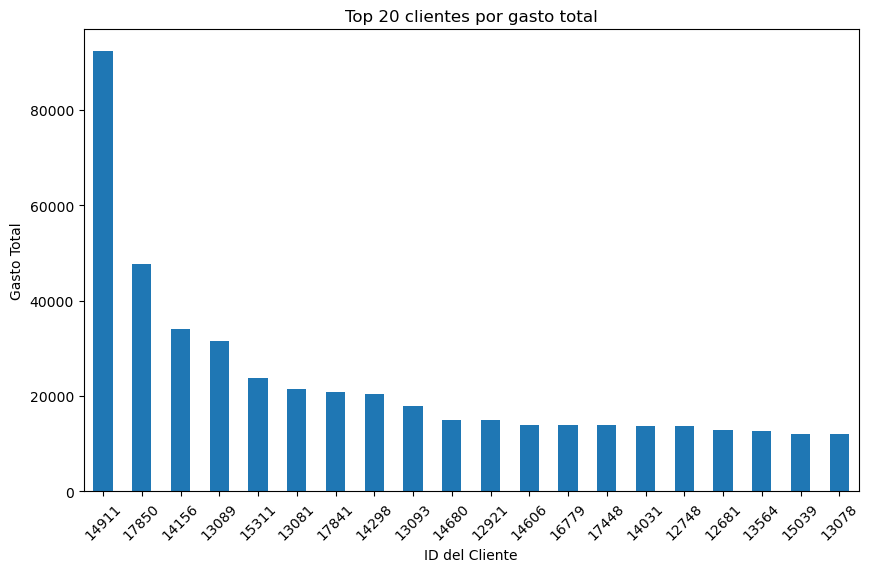

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

gasto = df.groupby('customer_id')['totalprice'].sum()

top_20 = gasto.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
top_20.plot(kind='bar')
plt.title("Top 20 clientes por gasto total")
plt.xlabel("ID del Cliente")
plt.ylabel("Gasto Total")
plt.xticks(rotation=45)
plt.show()



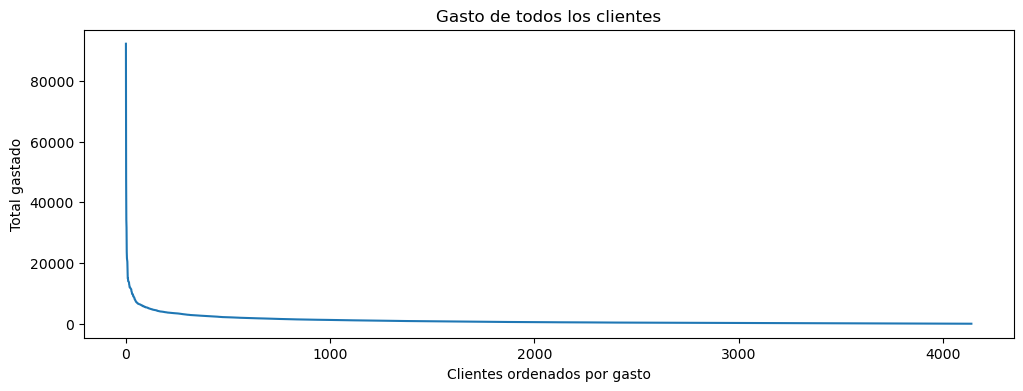

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(gasto.sort_values(ascending=False).values)
plt.title("Gasto de todos los clientes")
plt.ylabel("Total gastado")
plt.xlabel("Clientes ordenados por gasto")
plt.show()


In [ ]:
df['year'] = df['invoicedate'].dt.year
df['month'] = df['invoicedate'].dt.month
df['day'] = df['invoicedate'].dt.day
df['week'] = df['invoicedate'].dt.isocalendar().week
df['weekday'] = df['invoicedate'].dt.weekday   # 0 = lunes
df['hour'] = df['invoicedate'].dt.hour

df['year_month'] = df['invoicedate'].dt.to_period('M').astype(str)


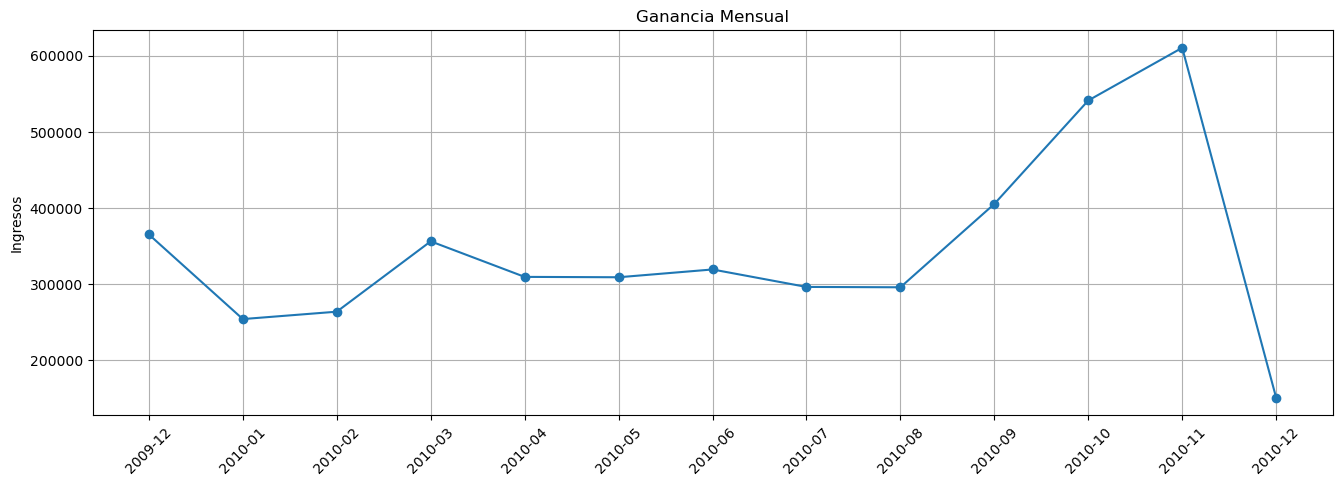

In [ ]:
monthly_revenue = df.groupby('year_month')['totalprice'].sum()

plt.figure(figsize=(16,5))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker="o")
plt.xticks(rotation=45)
plt.title("Ganancia Mensual")
plt.ylabel("Ingresos")
plt.grid(True)
plt.show()

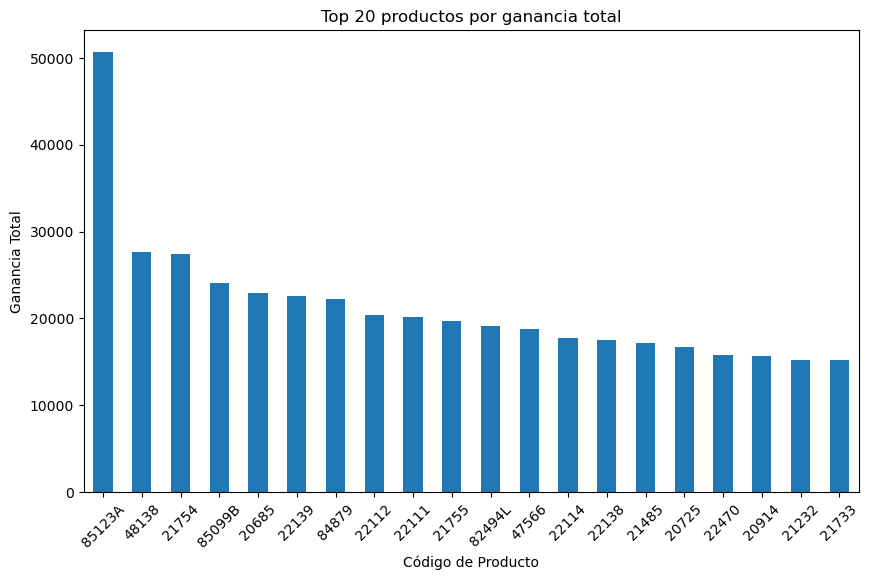

In [ ]:
df_clean = df[(df['price'] > 0) & (df['quantity'] > 0)]
df_clean['totalprice'] = df_clean['quantity'] * df_clean['price']

top_20_vendidos = (
    df_clean.groupby('stockcode')['totalprice']
            .sum()
            .sort_values(ascending=False)
            .head(20)
)

plt.figure(figsize=(10,6))
top_20_vendidos.plot(kind='bar')
plt.title("Top 20 productos por ganancia total")
plt.xlabel("Código de Producto")
plt.ylabel("Ganancia Total")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_clean = df[(df['price']> 0) & (df['quantity'] > 0)]

top_20_populares = (
  df_clean.groupby('stockcode')['invoice']
  .nunique()
  .sort_values(ascending=False)
  .head(20)
)

top_20_df = top_20_populares.reset_index()

In [ ]:
top_20_with_desc = top_20_df.merge(
    df_clean[['stockcode', 'description']].drop_duplicates(),
    on='stockcode',
    how='left'
)

top_20_with_desc


,stockcode,invoice,description
0,85123A,2374,WHITE HANGING HEART T-LIGHT HOLDER
1,85099B,1369,JUMBO BAG RED WHITE SPOTTY
2,85099B,1369,RED RETROSPOT JUMBO BAG
3,85099B,1369,JUMBO BAG RED RETROSPOT
4,21212,1256,PACK OF 72 RETRO SPOT CAKE CASES
5,21212,1256,PACK OF 72 RETROSPOT CAKE CASES
6,20725,1190,LUNCH BAG RED SPOTTY
7,20725,1190,LUNCH BAG RED RETROSPOT
8,21754,1171,HOME BUILDING BLOCK WORD
9,21232,1166,STRAWBERRY CERAMIC TRINKET BOX


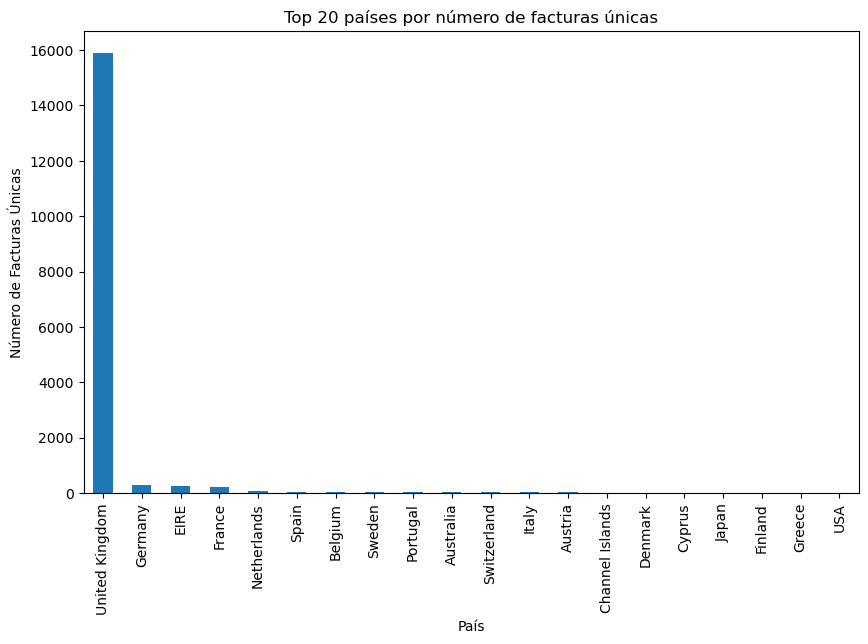

In [ ]:
top_20_paises = (
    df.groupby('country')['invoice']
      .nunique()
      .sort_values(ascending=False)
      .head(20)
)

plt.figure(figsize=(10,6))
top_20_paises.plot(kind='bar')
plt.title("Top 20 países por número de facturas únicas")
plt.xlabel("País")
plt.ylabel("Número de Facturas Únicas")
plt.show()


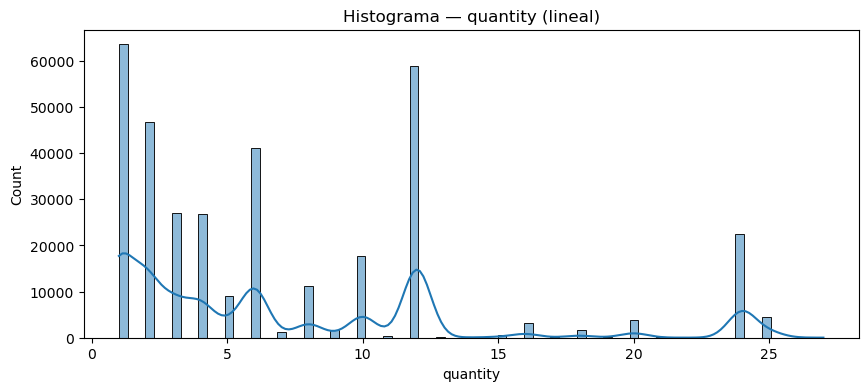

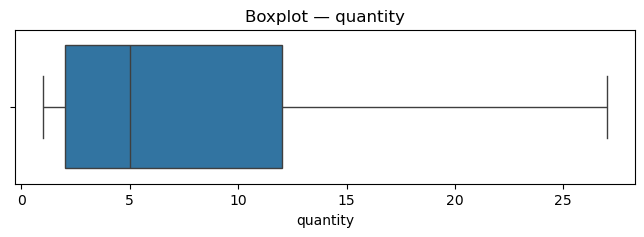

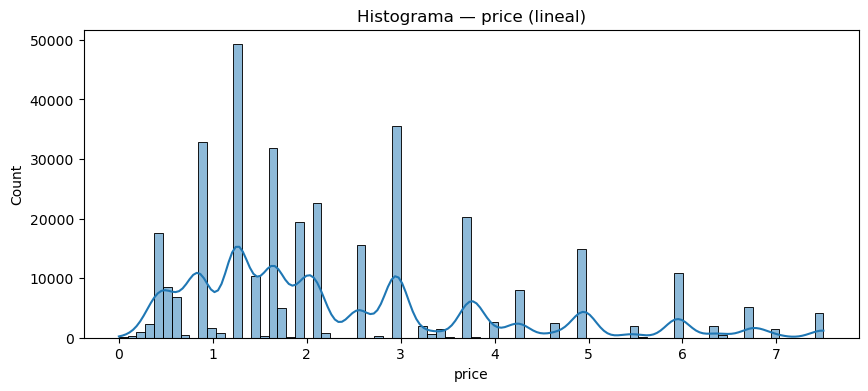

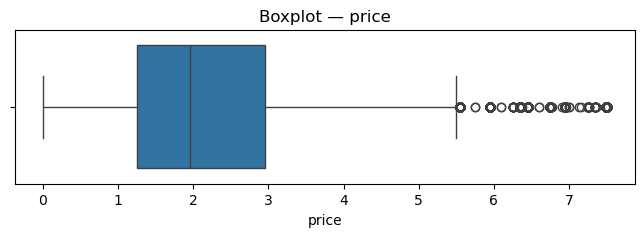

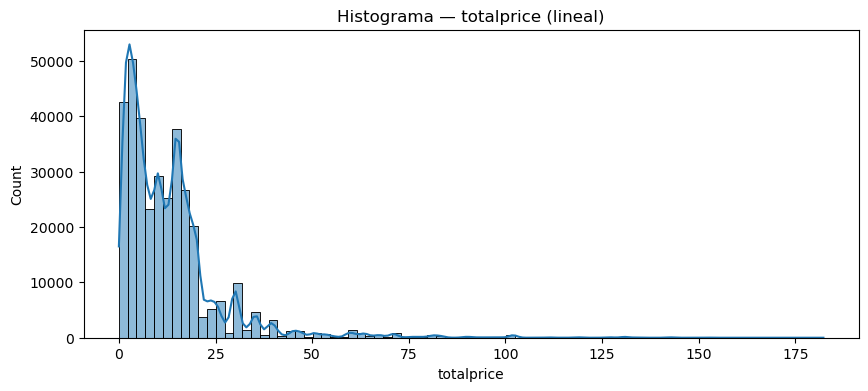

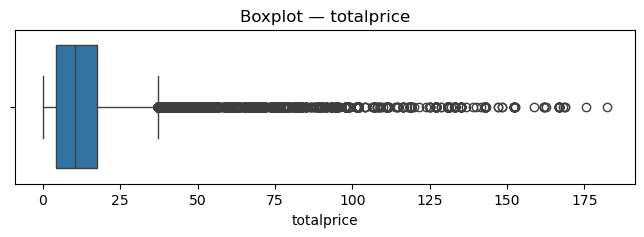

In [ ]:
df_clean = df.copy()

num_cols = ['quantity','price','totalprice']

for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df_clean[col], bins=80, kde=True)
    plt.title(f'Histograma — {col} (lineal)')
    plt.show()

    plt.figure(figsize=(8,2))
    sns.boxplot(x=df_clean[col])
    plt.title(f'Boxplot — {col}')
    plt.show()
